In [24]:
# !git clone https://github.com/Jsrsky/machine_unlearning_experiments
# %cd machine_unlearning_experiments/experiments/mnist/fisher

## Dependecies

In [25]:
import sys
import copy
from pathlib import Path
from torchvision import datasets

## Utils 

In [26]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [27]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

from utils.utils import save_model

from models.simple_cnn import load_model_cnn, init_model_cnn

# Merics 
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import iterative_fisher_unlearn, create_unlearning_dataloader

Device used: cuda


## Parameters (arbitrary chosen)

In [28]:
BATCH_SIZE = 2048
MINI_BATCH_SIZE = 4096

SIGMA = 0.5

EPS = 1e-2
MAX_NORM = 0.5
DEEP_CLEAN_THRESHOLD = 2

# CALL FISHER

### Files

In [29]:
model_file = project_root / 'experiments/mnist/naive/CNN_MNIST_model.pth'
samples_to_unlearn_file = project_root / 'experiments/mnist/naive/mnist_samples_to_unlearn_30per.json'
remaining_dataset_file = project_root / 'experiments/mnist/naive/updated_mnist_data_splits.json'

### Init models

In [30]:
original_model, original_model_name, criterion, _optimizer, transform = load_model_cnn(model_pth_path=model_file)

model_to_unlearn = copy.deepcopy(original_model)
import torch.nn as nn
model_to_unlearn = nn.DataParallel(model_to_unlearn, device_ids=[0, 1])

model_to_unlearn_name = 'fisher_' + original_model_name

Load model...
Init model...
Done initializing model.
Model ID: 134022120326672, Optimizer ID: 134021273698112, Criterion ID: 134021273695856
Done loading model.


## Init data

In [31]:
train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=True)

In [32]:
unlearn_indices, _unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

In [33]:
# train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
#     data_splits_file=remaining_dataset_file,
#     datasets=(train_dataset, test_dataset), 
#     batch_size=BATCH_SIZE)

# unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

In [34]:
import math
import json
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset

from utils.utils import DEVICE

def compute_gradient_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute the average gradient Δ_rem = ∇L(θ, D') over the given dataset_subset.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)
    
    grad_dict = {}
    total_samples = 0

    model.train()
    for inputs, targets in tqdm(dataloader, desc="Computing gradients"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        current_batch = inputs.size(0)
        total_samples += current_batch
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if name not in grad_dict:
                    grad_dict[name] = param.grad.detach().clone() * current_batch
                else:
                    grad_dict[name] += param.grad.detach() * current_batch

    # Average gradients over the entire subset
    for name in grad_dict:
        grad_dict[name] /= total_samples

    return grad_dict

def compute_fisher_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute a diagonal approximation of the Fisher Information Matrix F over the given dataset_subset.
    It averages the squared gradients.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)
    fisher_diag = {}
    total_samples = 0

    model.eval()
    for inputs, targets in tqdm(dataloader, desc="Computing Fisher"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        current_batch = inputs.size(0)
        total_samples += current_batch
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if name not in fisher_diag:
                    fisher_diag[name] = (param.grad.detach() ** 2) * current_batch
                else:
                    fisher_diag[name] += (param.grad.detach() ** 2) * current_batch

    for name in fisher_diag:
        fisher_diag[name] /= total_samples

    return fisher_diag
    # for name in fisher_diag:
    #     fisher_diag[name] /= total_samples
    # fisher_diag['_total_samples'] = total_samples

    return fisher_diag

def remove_from_fisher_incrementally(fisher_diag, model, criterion, dataset_removed, batch_size):
    dataloader = DataLoader(dataset_removed, batch_size=batch_size, shuffle=False)
    total_removed_samples = 0

    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        batch_samples = inputs.size(0)
        total_removed_samples += batch_samples
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                fisher_diag[name] -= (param.grad.detach() ** 2) * batch_samples

    total_samples_remaining = fisher_diag['_total_samples'] - total_removed_samples
    for name in fisher_diag:
        if name != '_total_samples':
            fisher_diag[name] = torch.clamp(fisher_diag[name], min=1e-8)
            fisher_diag[name] /= total_samples_remaining
    fisher_diag['_total_samples'] = total_samples_remaining

    return fisher_diag

def iterative_fisher_unlearn(model, criterion, full_dataset, removal_indices, sigma, deletion_batch_size, compute_batch_size, eps, max_norm):
    """
    Implements the iterative Fisher unlearning procedure following theory:
    
    Inputs:
      - model: a pretrained PyTorch model (trained on full dataset D).
      - criterion: loss function (e.g., CrossEntropyLoss).
      - full_dataset: the full training dataset D (e.g., MNIST training set).
      - removal_indices: list of indices (from the JSON file) to be deleted (Dₘ). E.g., 6000 samples.
      - sigma: noise parameter σ.
      - deletion_batch_size: desired mini-batch size for deletion (m′). E.g., 1000.
      - compute_batch_size: batch size used when computing gradients/Fisher (BATCH_SIZE).
      - eps: for numerical stability
    
    Procedure:
      1. Let current_indices = set(range(len(full_dataset))).
      2. Partition removal_indices into mini-batches of size deletion_batch_size.
      3. For each mini-batch, update current_indices by removing those indices.
      4. Create a Subset from full_dataset using current_indices (this is D').
      5. Compute Δ_rem and diagonal Fisher F on D' and update model:
             θ ← θ − F⁻¹ Δ_rem + σ · F^(–1/4) · ε.
    """
    full_size = len(full_dataset)
    current_indices = set(range(full_size))

    # Partition removal_indices into mini-batches, where s = m /m'
    removal_list = list(removal_indices)
    num_batches = math.ceil(len(removal_list) / deletion_batch_size)
    partitioned_removals = [removal_list[i * deletion_batch_size : (i + 1) * deletion_batch_size] for i in range(num_batches)]
    print(f"Total deletion samples: {len(removal_list)}; partitioned into {num_batches} mini-batches (each up to {deletion_batch_size} samples).")

    # NEWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW
    # fisher_diag = compute_fisher_on_subset(model, criterion, full_dataset, compute_batch_size)
    # NEWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW
    # Iterate over each deletion mini-batch
    for i, batch in enumerate(tqdm(partitioned_removals, desc="Fisher step over mini-batches")):
        # Remove the current batch of indices from current_indices
        current_indices -= set(batch)
        updated_indices = sorted(list(current_indices))
        # Create a Subset corresponding to the updated dataset D' = D \ (deleted so far)
        dataset_remaining = Subset(full_dataset, updated_indices)
        print(f"Iteration {i+1}/{num_batches}: Remaining dataset size = {len(dataset_remaining)}")
        # NEWWWWWWWWWWWWWWWWWWWWWWWWWW
        # dataset_removed = Subset(full_dataset, batch)
        # fisher_diag = remove_from_fisher_incrementally(fisher_diag, model, criterion, dataset_removed, compute_batch_size)
        # NEWWWWWWWWWWWWWWWWWWWWWWWWWWW
        # Compute the average gradient and diagonal Fisher on D'
        grad_dict = compute_gradient_on_subset(model, criterion, dataset_remaining, compute_batch_size)
        fisher_diag = compute_fisher_on_subset(model, criterion, dataset_remaining, compute_batch_size)



        # dataset_removed = Subset(full_dataset, batch) # For DeepClean
        # fisher_forget = compute_fisher_on_subset(model, criterion, dataset_removed, deletion_batch_size)
        # update_masks = {}
        # for name in fisher_forget:
        #     ratio = (fisher_forget[name] + eps) / (fisher_diag[name] + eps)
        #     update_masks[name] = ratio > DEEP_CLEAN_THRESHOLD






        
        # Update model parameters using the Newton correction and noise injection
        with torch.no_grad():
            for name in grad_dict:
                grad = grad_dict[name]
                norm = grad.norm(2).item()
                grad_min = grad.min().item()
                grad_max = grad.max().item()
                grad_mean = grad.mean().item()
                grad_std = grad.std().item()
                print(f"[Raw] Param {name}: norm = {norm:.4e}, min = {grad_min:.4e}, max = {grad_max:.4e}, mean = {grad_mean:.4e}, std = {grad_std:.4e}")
            
            # First, compute and clip gradients, and monitor norms
            total_grad_norm_before = 0.0
            total_grad_norm_after = 0.0
            for name in grad_dict:
                norm_before = grad_dict[name].norm(2)
                total_grad_norm_before += norm_before.item()
                if norm_before > max_norm:
                    grad_dict[name] = grad_dict[name] * (max_norm / norm_before)
                norm_after = grad_dict[name].norm(2)
                total_grad_norm_after += norm_after.item()
            
            print(f"Iteration {i+1}: Total gradient norm before clipping = {total_grad_norm_before:.4f}")
            print(f"Iteration {i+1}: Total gradient norm after clipping  = {total_grad_norm_after:.4f}")
            
            # Now, update model parameters using the clipped gradients and monitor the Newton update norm
            total_update_norm = 0.0
            for name, param in model.named_parameters():
                if param.requires_grad:


                    # #DeepClean
                    # mask = update_masks.get(name, torch.zeros_like(param.data, dtype=torch.bool))
                    # if mask.any():
                    #     inv_fisher = (fisher_diag[name] + eps).pow(-1)
                    #     newton_update = inv_fisher * grad_dict[name]
    
                    #     param.data[mask] -= newton_update[mask]
    
                    #     inv_fisher_quarter = (fisher_diag[name] + eps).pow(-0.25)
                    #     noise = torch.randn_like(param.data)
                    #     param.data[mask] += sigma * inv_fisher_quarter[mask] * noise[mask]
                    # else:
                    #     continue 

                    
                    inv_fisher = (fisher_diag[name] + eps).pow(-1)
                    newton_update = inv_fisher * grad_dict[name]
                    total_update_norm += newton_update.norm(2).item()
                    param.data = param.data - newton_update

                    inv_fisher_quarter = (fisher_diag[name] + eps).pow(-0.25)
                    noise = torch.randn_like(param.data)
                    param.data = param.data + sigma * inv_fisher_quarter * noise

            print(f"Iteration {i+1}: Total Newton update norm = {total_update_norm:.4f}")
        print(f"Iteration {i+1}/{num_batches} update completed.")
        
    return model

In [35]:
import time
start_time = time.perf_counter()

unlearned_model = iterative_fisher_unlearn(
    model_to_unlearn,
    criterion,
    train_dataset,
    unlearn_indices,
    SIGMA,
    deletion_batch_size=MINI_BATCH_SIZE,
    compute_batch_size=BATCH_SIZE,
    eps=EPS,
    max_norm=MAX_NORM,
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Total deletion samples: 18000; partitioned into 5 mini-batches (each up to 4096 samples).


Fisher step over mini-batches:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration 1/5: Remaining dataset size = 55904



Computing gradients: 100%|██████████| 28/28 [00:10<00:00,  2.59it/s]

Fisher step over mini-batches:  20%|██        | 1/5 [00:21<01:26, 21.63s/it]

[Raw] Param module.conv1.weight: norm = 1.4423e-02, min = -2.7832e-03, max = 2.5161e-03, mean = -6.7672e-05, std = 8.4866e-04
[Raw] Param module.conv1.bias: norm = 7.5560e-03, min = -3.0531e-03, max = 2.3388e-03, mean = 5.5989e-05, std = 1.3559e-03
[Raw] Param module.conv2.weight: norm = 2.1472e-02, min = -6.0332e-04, max = 1.6953e-03, mean = 5.9106e-06, std = 1.5805e-04
[Raw] Param module.conv2.bias: norm = 1.9664e-03, min = -3.6729e-04, max = 9.4029e-04, mean = 1.0861e-05, std = 2.4750e-04
[Raw] Param module.fc1.weight: norm = 2.6361e-02, min = -1.1504e-03, max = 1.4016e-03, mean = 1.1217e-06, std = 4.1592e-05
[Raw] Param module.fc1.bias: norm = 1.0607e-03, min = -2.7952e-04, max = 3.3593e-04, mean = 6.8432e-06, std = 9.3869e-05
[Raw] Param module.fc2.weight: norm = 8.1308e-02, min = -1.9371e-02, max = 1.0968e-02, mean = 1.6838e-09, std = 2.2735e-03
[Raw] Param module.fc2.bias: norm = 2.2782e-03, min = -1.7627e-03, max = 1.0019e-03, mean = 8.7894e-10, std = 7.5942e-04
Iteration 1: To


Computing gradients: 100%|██████████| 26/26 [00:09<00:00,  2.66it/s]

Fisher step over mini-batches:  40%|████      | 2/5 [00:41<01:01, 20.60s/it]

[Raw] Param module.conv1.weight: norm = 2.1997e+04, min = -3.4548e+03, max = 2.6015e+03, mean = -9.2370e+01, std = 1.2952e+03
[Raw] Param module.conv1.bias: norm = 7.8883e+03, min = -2.2621e+03, max = 3.3467e+03, mean = 4.2866e+02, std = 1.3482e+03
[Raw] Param module.conv2.weight: norm = 2.0589e+04, min = -1.5146e+03, max = 1.6494e+03, mean = 4.2418e+01, std = 1.4560e+02
[Raw] Param module.conv2.bias: norm = 4.5376e+02, min = -1.4602e+02, max = 1.4180e+02, mean = 2.0343e+01, std = 5.3364e+01
[Raw] Param module.fc1.weight: norm = 2.1454e+04, min = -3.2087e+02, max = 4.1126e+02, mean = 7.2059e+00, std = 3.3087e+01
[Raw] Param module.fc1.bias: norm = 6.1383e+00, min = -1.5760e+00, max = 2.0589e+00, mean = 1.6880e-01, std = 5.1765e-01
[Raw] Param module.fc2.weight: norm = 2.0717e+04, min = -1.7556e+03, max = 5.1307e+03, mean = -1.5736e-06, std = 5.7928e+02
[Raw] Param module.fc2.bias: norm = 5.0917e-01, min = -1.1147e-01, max = 3.2215e-01, mean = 1.4901e-09, std = 1.6972e-01
Iteration 2: T


Computing gradients: 100%|██████████| 24/24 [00:09<00:00,  2.59it/s]

Fisher step over mini-batches:  60%|██████    | 3/5 [00:59<00:39, 19.60s/it]

[Raw] Param module.conv1.weight: norm = 2.5126e+04, min = -4.0137e+03, max = 3.8474e+03, mean = -1.2313e+02, std = 1.4780e+03
[Raw] Param module.conv1.bias: norm = 8.7842e+03, min = -3.3807e+03, max = 3.9339e+03, mean = 4.0178e+02, std = 1.5240e+03
[Raw] Param module.conv2.weight: norm = 2.3410e+04, min = -1.4746e+03, max = 1.9677e+03, mean = 4.4088e+01, std = 1.6671e+02
[Raw] Param module.conv2.bias: norm = 5.1528e+02, min = -1.4151e+02, max = 1.7032e+02, mean = 2.1337e+01, std = 6.1254e+01
[Raw] Param module.fc1.weight: norm = 2.4013e+04, min = -4.0571e+02, max = 4.1421e+02, mean = 7.5269e+00, std = 3.7146e+01
[Raw] Param module.fc1.bias: norm = 6.9515e+00, min = -2.0243e+00, max = 2.0913e+00, mean = 1.7785e-01, std = 5.9044e-01
[Raw] Param module.fc2.weight: norm = 2.2617e+04, min = -1.8005e+03, max = 6.7523e+03, mean = 2.7046e-07, std = 6.3241e+02
[Raw] Param module.fc2.bias: norm = 5.4979e-01, min = -1.1125e-01, max = 4.1264e-01, mean = 2.9802e-09, std = 1.8326e-01
Iteration 3: To


Computing gradients: 100%|██████████| 22/22 [00:08<00:00,  2.60it/s]

Fisher step over mini-batches:  80%|████████  | 4/5 [01:16<00:18, 18.43s/it]

[Raw] Param module.conv1.weight: norm = 2.5698e+04, min = -4.1923e+03, max = 3.7784e+03, mean = -1.9516e+02, std = 1.5043e+03
[Raw] Param module.conv1.bias: norm = 8.9919e+03, min = -3.2492e+03, max = 4.1603e+03, mean = 4.6055e+02, std = 1.5457e+03
[Raw] Param module.conv2.weight: norm = 2.5196e+04, min = -1.3798e+03, max = 2.1298e+03, mean = 4.5256e+01, std = 1.7999e+02
[Raw] Param module.conv2.bias: norm = 5.5236e+02, min = -1.4071e+02, max = 1.8899e+02, mean = 2.3224e+01, std = 6.5536e+01
[Raw] Param module.fc1.weight: norm = 2.6078e+04, min = -4.3217e+02, max = 4.4077e+02, mean = 7.6551e+00, std = 4.0442e+01
[Raw] Param module.fc1.bias: norm = 7.5748e+00, min = -2.1725e+00, max = 2.1822e+00, mean = 1.8101e-01, std = 6.4712e-01
[Raw] Param module.fc2.weight: norm = 2.4117e+04, min = -1.6955e+03, max = 7.6698e+03, mean = 1.5348e-06, std = 6.7436e+02
[Raw] Param module.fc2.bias: norm = 5.9215e-01, min = -1.1189e-01, max = 5.0730e-01, mean = -1.4901e-09, std = 1.9738e-01
Iteration 4: T


Computing gradients: 100%|██████████| 21/21 [00:08<00:00,  2.61it/s]

Fisher step over mini-batches: 100%|██████████| 5/5 [01:32<00:00, 18.50s/it]

[Raw] Param module.conv1.weight: norm = 2.8009e+04, min = -5.1194e+03, max = 3.0373e+03, mean = -1.6569e+02, std = 1.6450e+03
[Raw] Param module.conv1.bias: norm = 1.0141e+04, min = -2.7641e+03, max = 5.1073e+03, mean = 4.8137e+02, std = 1.7545e+03
[Raw] Param module.conv2.weight: norm = 2.4872e+04, min = -1.6277e+03, max = 2.0745e+03, mean = 4.1846e+01, std = 1.7836e+02
[Raw] Param module.conv2.bias: norm = 5.4587e+02, min = -1.3755e+02, max = 2.1643e+02, mean = 1.9657e+01, std = 6.5858e+01
[Raw] Param module.fc1.weight: norm = 2.5017e+04, min = -4.0049e+02, max = 4.1363e+02, mean = 8.4187e+00, std = 3.8579e+01
[Raw] Param module.fc1.bias: norm = 7.2289e+00, min = -2.0015e+00, max = 2.0927e+00, mean = 1.9868e-01, std = 6.0966e-01
[Raw] Param module.fc2.weight: norm = 2.2669e+04, min = -1.7388e+03, max = 6.1595e+03, mean = -6.5565e-08, std = 6.3388e+02
[Raw] Param module.fc2.bias: norm = 5.5160e-01, min = -1.1210e-01, max = 4.0266e-01, mean = 0.0000e+00, std = 1.8387e-01
Iteration 5: T

In [40]:
save_model(unlearned_model, f'{model_to_unlearn_name}_model.pth')

### Test and metrics

In [41]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = test_dataset.classes

In [42]:
model, *_ = init_model_cnn()
model = nn.DataParallel(model, device_ids=[0, 1])
model_path = f"{model_to_unlearn_name}_model.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader)

Init model...
Done initializing model.
Model ID: 134021423999840, Optimizer ID: 134021272023536, Criterion ID: 134022119922064
Loading and testing model: fisher_CNN_MNIST


Evaluating model: fisher_CNN_MNIST_model.pth:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating model: fisher_CNN_MNIST_model.pth: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

Predictions and labels saved to fisher_CNN_MNIST_predictions.json


Metrics for fisher_CNN_MNIST:
  - Test Accuracy: 0.1295
  - Precision: 0.0442
  - Recall: 0.1295
  - F1 Score: 0.0620


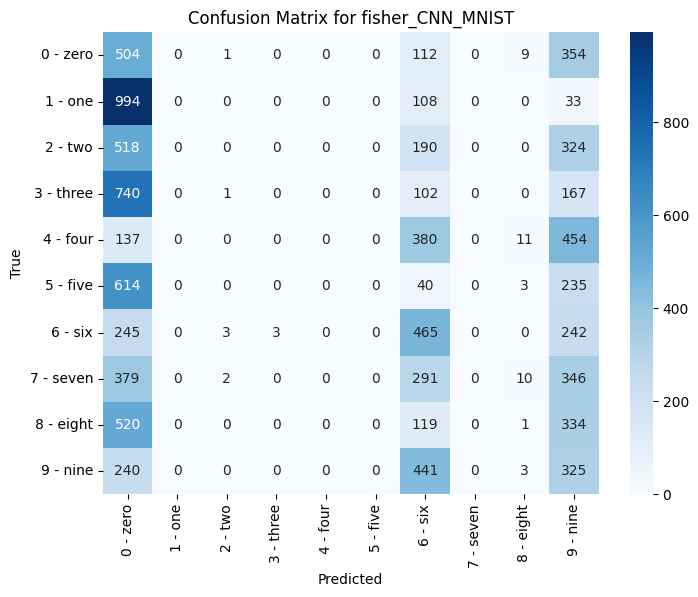

In [43]:
predictions_path = f'{model_to_unlearn_name}_predictions.json'
# classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
show_metrics(predictions_path, classes, model_to_unlearn_name)